# Import libraries

In [1]:
# !pip install matplotlib

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Interesting raw data information
* The source files do not contain a consolidated combination of inputs and outputs.
    * Rather, it seems that we have an applications file, with an associated credit status file.
    * Together, these would serve as potential inputs for a machine learning task, but we would have to create a new output or target.
* Best approach is to load both files in and see what we are dealing with.

In [3]:
app_raw = pd.read_csv('application_record.csv')
credit_raw = pd.read_csv('credit_record.csv')

In [4]:
app_raw.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
credit_raw.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


#### Note
* Thankfully both the application and status files contain a common "# ID" column. Joining on this column would make the most sense.
* Empty values will not be of much use here, for that reason an inner join will serve us best.

In [ ]:
# Merge the two DataFrames on the 'ID' column

merged_df = pd.merge(app_raw, credit_raw, on='ID', how='inner')
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [7]:
print(len(app_raw), len(credit_raw), len(merged_df))

438557 1048575 777715


In [8]:
print(app_raw['ID'].nunique(), credit_raw['ID'].nunique(), merged_df['ID'].nunique())

438510 45985 36457


### Application/ Status Imbalances
* Comparing the raw counts of each file shows imbalances:
    * Applications: ~439k rows
    * Statuses: ~1M rows
* However, when combined on the inner join, the result is approximately **780k rows**.
* This means there has to be duplicates. Further investigation required.

# Investigating Credit Status
* Starting with credit status file because it has fewer columns

In [9]:
credit_raw.describe(include='all')

,ID,MONTHS_BALANCE,STATUS
count,1.048575e+06,1.048575e+06,1048575
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,442031
mean,5.068286e+06,-1.913700e+01,NaN
std,4.615058e+04,1.402350e+01,NaN
min,5.001711e+06,-6.000000e+01,NaN
25%,5.023644e+06,-2.900000e+01,NaN
50%,5.062104e+06,-1.700000e+01,NaN
75%,5.113856e+06,-7.000000e+00,NaN


In [10]:
credit_raw

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


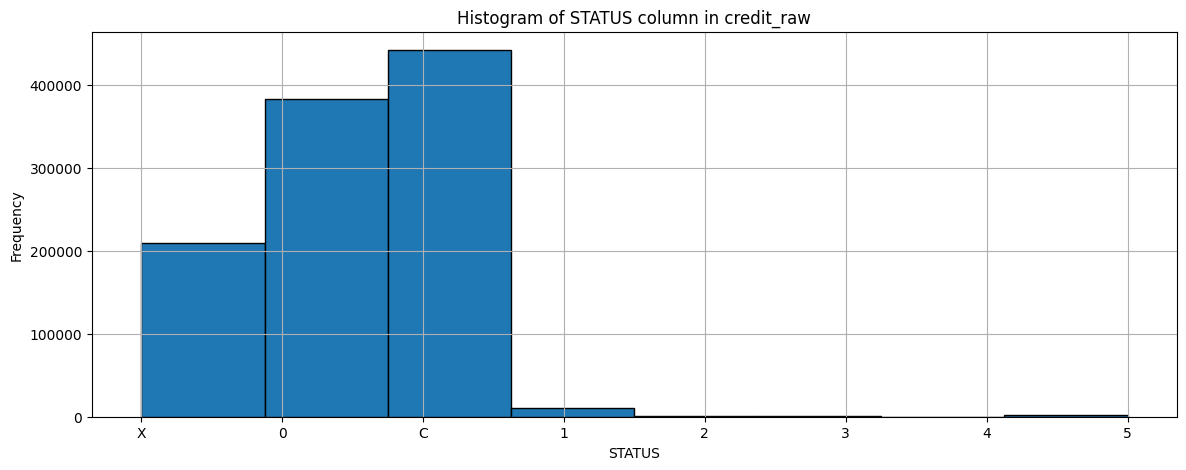

In [11]:
# Status column histogram

plt.figure(figsize=(14,5))
credit_raw['STATUS'].hist(bins=len(credit_raw['STATUS'].unique()), edgecolor='black')
plt.title('Histogram of STATUS column in credit_raw')
plt.xlabel('STATUS')
plt.ylabel('Frequency')
plt.show()

There are over 400k counts of loans being paid off, with the second highest frequency term being loans that are overdue by 1-29 days as explained in the README.md file. It would be interesting to visualise the count of member IDs according to each status to better gauge how the various statuses are spread among the members.

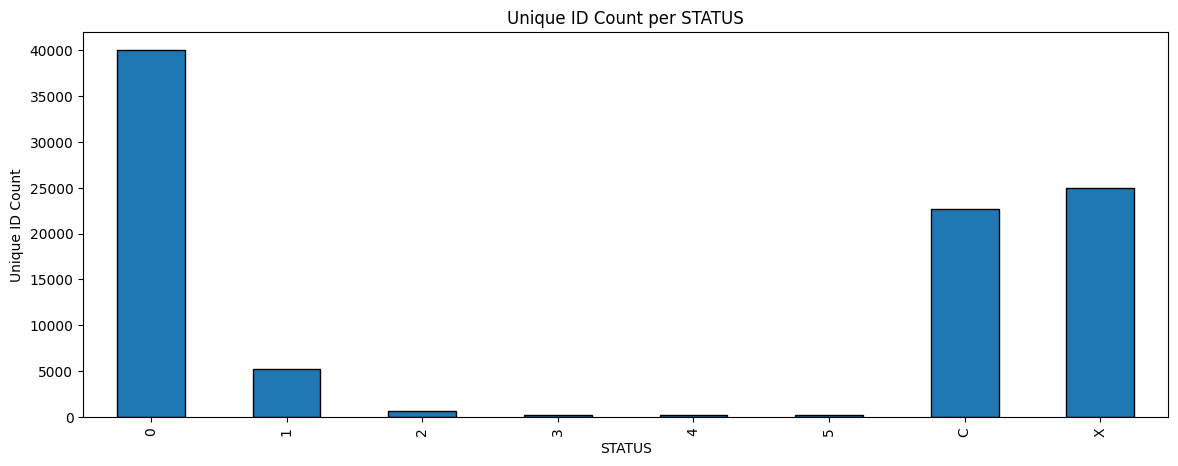

In [12]:
# Bar graph: count of unique IDs per STATUS

status_id_counts = credit_raw.groupby('STATUS')['ID'].nunique().sort_index()
plt.figure(figsize=(14,5))
status_id_counts.plot(kind='bar', edgecolor='black')
plt.title('Unique ID Count per STATUS')
plt.xlabel('STATUS')
plt.ylabel('Unique ID Count')
plt.show()

The above graph paints a different picture.
* The status with the most unique IDs is actually for members that have loans overdue by 1-29 days.
* On the other hand, the number of unique individuals paying off their loans has dropped quite a bit. 
    * Given that the number of completed loan repayments has a count of 400k (the highest accounted for status), but the number of unique members that have ever completed loan repayments is under 25k, this suggests that it is the same members who are taking multiple loans and then repaying them to completion. 
        * These members can be considered as "seasoned borrowers"

In [ ]:
# Count of STATUS == 'C' grouped by ID

status_c_counts = credit_raw[credit_raw['STATUS'] == 'C'].groupby('ID').size()
status_c_counts = status_c_counts.sort_values(ascending=False)
status_c_counts

ID
5120983    60
5012282    60
5097084    59
5012586    59
5121993    58
           ..
5105013     1
5033730     1
5136978     1
5136973     1
5001729     1
Length: 22707, dtype: int64

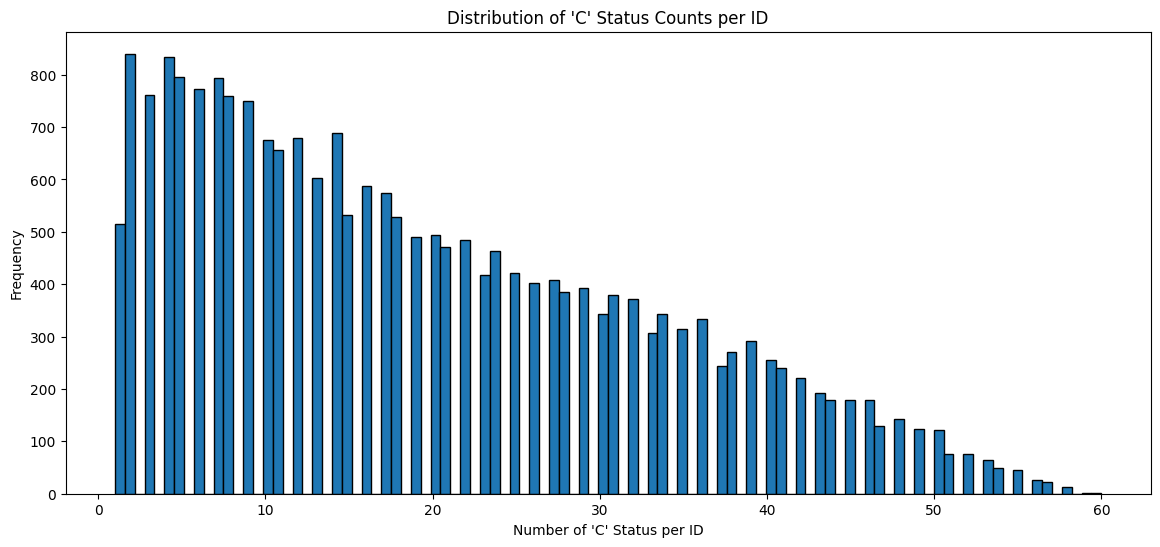

In [14]:
plt.figure(figsize=(14,6))
status_c_counts.plot(kind='hist', bins=100, edgecolor='black')
plt.title("Distribution of 'C' Status Counts per ID")
plt.xlabel("Number of 'C' Status per ID")
plt.ylabel("Frequency")
plt.show()

* The above distribution proves it - we can see that there are several members who took multiple loans, ranging from 2 all the way up to 60.
    * This explains the the high number of C statuses. 
* Based off the previous bar graph, it is also clear that most members actually paid off their loans within 1 month - this is pretty good.
    * The second highest length of time for completed loan repayments was 30-59 days.

### Establishing a target variable
* This dataset does not come with a dedicated target variable. Rather, one should be created based on the time it takes for members to repay their loans.
* To this end, we may use a **vintage analysis**.

### What is a Vintage Analysis?
* Vintage analysis is a very common credit-risk management tool
* Simply, it measures the performance of a loan across different periods of time after that loan was taken.
* By analysing loan performance across subsequent months for loans taken in the same month, conclusions may be drawn about loan performance relative to the time period in which the loans were taken.

The necessary EDA and data transformations for the vintage analysis will be performed below.

In [ ]:
credit_group= credit_raw.groupby('ID')

# Pivot credit_raw to wide format, grouped by 'ID'

credit_pivot = credit_raw.pivot_table(index='ID', columns='MONTHS_BALANCE', values='STATUS', aggfunc='first')
credit_pivot.head(20)

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
5001717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,C,C,C,C,C
5001718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,1,0,0,0,0,0,C,C,C
5001719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,C,C,C,C,C,C,C,C,C
5001720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,1,0,1,1,0,0,1


* In the above, wide table format, calculating metrics on an ID basis becomes easier.
* We need to assign the lowest and highest month repayment number for each ID row.

In [20]:
credit_pivot['start_month'] = credit_group['MONTHS_BALANCE'].min()
credit_pivot['end_month'] = credit_group['MONTHS_BALANCE'].max()

In [21]:
credit_pivot['ID'] = credit_pivot.index

In [22]:
credit_pivot = credit_pivot[['ID', 'start_month', 'end_month']]

In [ ]:
credit_pivot['window'] = credit_pivot['end_month'] - credit_pivot['start_month']

In [26]:
credit_pivot.reset_index(drop = True, inplace = True)

In [ ]:
# join calculated information

credit = pd.merge(credit_raw, credit_pivot, on = 'ID', how = 'left')

In [48]:
credit.head()

,ID,MONTHS_BALANCE,STATUS,start_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18


With the above dataframe established, we can make a copy from here in order to preserve the original frame for further analysis later.

In [49]:
credit_copy = credit.copy()

* Let's visualise the latest dataframe in terms of loan window sizes to gain a better idea of what we are dealing with

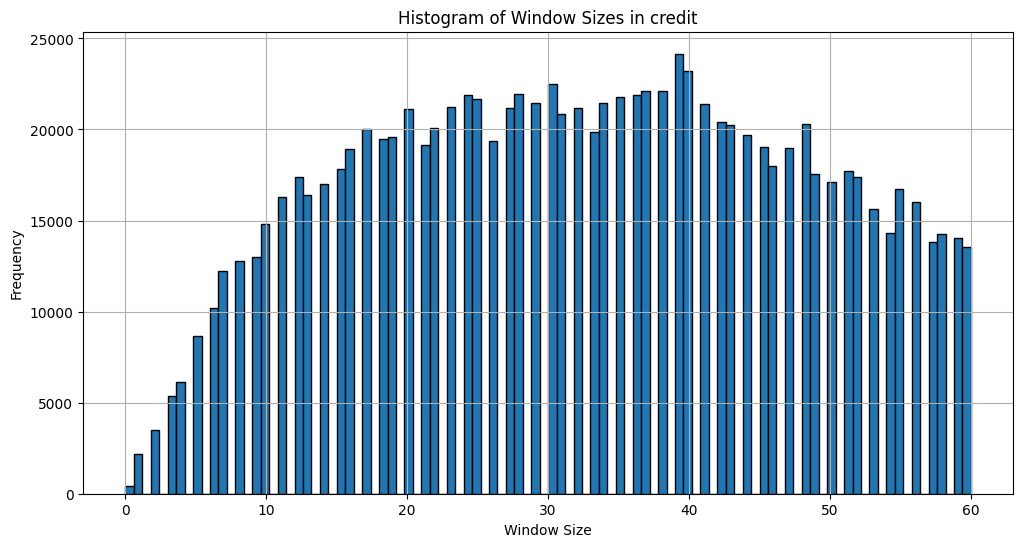

In [ ]:
# Histogram of 'window' sizes from credit

plt.figure(figsize=(12,6))
credit['window'].hist(bins=100, edgecolor='black')
plt.title('Histogram of Window Sizes in credit')
plt.xlabel('Window Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Count the number of accounts/rows with window sizes 10 and less

count_window_10_or_less = (credit['window'] <= 10).sum()
print("Number of accounts/rows with window size 10 or less:", count_window_10_or_less)
print("As a percentage of the total data:", round((count_window_10_or_less / len(credit)) * 100, 2), "%")

Number of accounts/rows with window size 10 or less: 89242
As a percentage of the total data: 8.51 %


Keeping data for accounts with windows less than 10 months will skew the data. We will remove them for a more uniform distribution which will assist with the machine learning to take place further on in the analysis. Removing these accounts only accounts for **8.5%**, and thus does not severely limit our analysis.

In [52]:
credit = credit[credit['window'] > 10] # focus on accounts that have been around for more than 10 months.

In [53]:
credit.head()

,ID,MONTHS_BALANCE,STATUS,start_month,end_month,window
4,5001712,0,C,-18,0,18
5,5001712,-1,C,-18,0,18
6,5001712,-2,C,-18,0,18
7,5001712,-3,C,-18,0,18
8,5001712,-4,C,-18,0,18


### Creating the target variable
At this stage we have a clear way forward for creating the target variable.
* We have a series of accounts with labelled window periods for account repayments, as well as the status thereof.
* The key here will be the status column - it will inform us of loan delinquency for each account.
    * We will define a loan to be delinquent after 2 months of not paying, which translates to status 3 and higher.

In [ ]:
# marks loans past 60 days

credit['delinquent'] = np.where((credit['STATUS'] == '3') | (credit['STATUS'] == '4' ) | (credit['STATUS'] == '5' ), 1, 0) 

In [55]:
credit['book_months'] = credit['MONTHS_BALANCE'] - credit['start_month']

In [ ]:
# sort descending for easier time series analysis

credit.sort_values(by = ['ID','month_on_book'], inplace = True)